# Data process

Suppose submodule is pulled, we now

1. Download label data from the website.
2. Parse those data, filter out useless properties, and save them as a csv file.
   - each data item contains 
     1. the btor2 file name
     2. the validator
     3. the result

In [3]:
import urllib
# user should set their own proxy...
proxies = {'https': 'http://172.17.128.1:7890', 'http': 'http://172.17.128.1:7890', 'all': 'sock5://172.17.128.1:7891'}

**Download and decompress the labels.**

In [4]:
import requests
from bs4 import BeautifulSoup
import re

url = "https://www.cip.ifi.lmu.de/~chien/benchexec-results/btor2c-eval/final-full-results/"

# Send a GET request to the URL
response = requests.get(url, proxies=proxies)

print(response)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Find all <a> tags that contain the file links
file_links = soup.find_all("a")

# Extract the href attribute from each <a> tag
file_names = [link.get("href") for link in file_links]

<Response [200]>


In [5]:
tools = ["cpachecker", "esbmc", "veriabs"]

# Define the regular expression pattern
# <tool_name>-lazyMod.*.results.*.bv-64.xml.bz2
pattern = fr"({'|'.join(tools)})-lazyMod.*.results.*.bv-64.xml.bz2"
print(pattern)
# Filter file_names using the pattern
filtered_file_names = [file_name for file_name in file_names if re.fullmatch(pattern, file_name)]

# Print the filtered file names
for file_name in filtered_file_names:
    print(file_name)

(cpachecker|esbmc|veriabs)-lazyMod.*.results.*.bv-64.xml.bz2
cpachecker-lazyMod.2023-01-17_17-25-41.results.predAbs.bv-64.xml.bz2
cpachecker-lazyMod.2023-01-18_01-24-33.results.bmc-boolector-noPtrAlias.bv-64.xml.bz2
esbmc-lazyMod.2023-01-17_19-41-45.results.kind.bv-64.xml.bz2
esbmc-lazyMod.2023-01-18_02-08-43.results.bmc.bv-64.xml.bz2
veriabs-lazyMod.2023-01-17_22-40-24.results.default.bv-64.xml.bz2


In [10]:
import os
import shutil

base_url = "https://www.cip.ifi.lmu.de/~chien/benchexec-results/btor2c-eval/final-full-results/"
label_directory = "labels/"

for file_name in filtered_file_names:
    url = base_url + file_name
    destination = label_directory + file_name
    
    if not os.path.exists(destination):
        with requests.get(url, proxies=proxies, stream=True) as r:
            with open(destination, 'wb') as f:
                shutil.copyfileobj(r.raw, f)

In [11]:
import bz2
import os

# Loop through each bz2 file in the directory
for file_name in filtered_file_names:
    bz2_file_path = label_directory + file_name
    extract_path = label_directory + file_name[:-4]  # Remove the .bz2 extension
    
    # Open the bz2 file
    with bz2.open(bz2_file_path, 'rb') as bz2_file:
        # Read the compressed data
        data = bz2_file.read()
        
        # Write the decompressed data to a new file
        with open(extract_path, 'wb') as extract_file:
            extract_file.write(data)


**parse the xml label files to csv files.**

In [16]:
import yaml

# Load the config.yaml file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Access the value of dataset.path
dataset_path = config['path']['dataset']
btor2c_path = config['path']['btor2c']
# Print the dataset path
print(dataset_path, btor2c_path)

tool_configs = [
    'cpachecker-predAbs', 
    'cpachecker-noPtrAlias', 
    'esbmc-kind', 
    'esbmc-bmc', 
    'veriabs-default'
]

word-level-hwmc-benchmarks/bv/btor2/ btor2c/build/btor2c


In [25]:
xml_label_files = [label_directory + file_name[:-4] for file_name in filtered_file_names]

import xml.etree.ElementTree as ET

runs = []

for xml_file in xml_label_files:
    run = []
    tool_config = 'cpachecker-predAbs'    if 'cpachecker' in xml_file       \
                                         and 'predAbs' in xml_file else     \
                  'cpachecker-noPtrAlias' if 'cpachecker' in xml_file       \
                                         and 'noPtrAlias' in xml_file else  \
                  'esbmc-kind'            if 'esbmc' in xml_file            \
                                         and  'kind' in xml_file else       \
                  'esbmc-bmc'             if 'esbmc' in xml_file            \
                                         and 'bmc' in xml_file else        \
                  'veriabs-default' # if 'veriabs' in xml_file else 
    tree = ET.parse(xml_file)
    root = tree.getroot()
    run_children = root.findall('run')
    for run_node in run_children:
        parent_dir = os.path.basename(os.path.dirname(run_node.attrib['files'])) + "/"
        item = {
            'yml': dataset_path + parent_dir + os.path.basename(run_node.attrib['name']),
            'btor2': dataset_path + parent_dir + os.path.basename(run_node.attrib['files'][:-2]) + 'btor2',
            'c': dataset_path + parent_dir + os.path.basename(run_node.attrib['files'][:-1]),
            'property': run_node.attrib['properties'],
            'propertyFile': dataset_path + "../../properties/" + os.path.basename(run_node.attrib['propertyFile']),
            'expectedVerdict': run_node.attrib['expectedVerdict'],
            'tool_config': tool_config
        }
        # run_node.attrib
        properties = run_node.findall('column')
        for property_node in properties:
            if property_node.attrib['title'] == 'cputime':
                item['cputime'] = float(property_node.attrib['value'][:-1])
            elif property_node.attrib['title'] == 'memory':
                item['memory'] = int(property_node.attrib['value'][:-1])
            elif property_node.attrib['title'] == 'status':
                item['status'] = \
                    'TRUE' if 'true' in property_node.attrib['value'] else \
                    'FALSE' if 'false' in property_node.attrib['value'] else \
                    'FAILED'
        run.append(item)
    runs.append(run)
# we have 5 files, each of them contains 1342 items
print(runs[0][0])

{'yml': 'word-level-hwmc-benchmarks/bv/btor2/beem/adding.1.prop1-back-serstep.yml', 'btor2': 'word-level-hwmc-benchmarks/bv/btor2/beem/adding.1.prop1-back-serstep.btor2', 'c': 'word-level-hwmc-benchmarks/bv/btor2/beem/adding.1.prop1-back-serstep.c', 'property': 'unreach-call', 'propertyFile': 'word-level-hwmc-benchmarks/bv/btor2/../../properties/unreach-call.prp', 'expectedVerdict': 'false', 'tool_config': 'cpachecker-predAbs', 'cputime': 901.71803173, 'memory': 346869760, 'status': 'FAILED'}


**Note that we need to invoke btor2c**

In [ ]:
import subprocess
for run in runs:
    for test in run:
        if not os.path.exists(test['c']):
            subprocess.run([btor2c_path, test['btor2'], '-o', test['c']])

In [26]:
for run in runs:
    for test in run:
        if not os.path.exists(test['btor2']):
            print(test['btor2'])
        if not os.path.exists(test['yml']):
            print(test['yml'])
        if not os.path.exists(test['c']):
            print(test['c'])
        if not os.path.exists(test['propertyFile']):
            print(test['propertyFile'])

TODO: cputime, status, memory need to be summarized into one property 

In [28]:
import json
import pickle
import json

# Dump the runs dictionary into a pickle file
with open('runs.pickle', 'wb') as file:
    pickle.dump(runs, file)

# # Dump the runs variable as JSON
# with open('runs.json', 'w') as file:
#     json.dump(runs, file)


**Now we try to build features for the data**

In fact, this is the most important part of the whole project: extract good features for btor2 format to facilitate the algorithm selection.

1. We can make use of the [software verification algorithm selection project](https://github.com/cedricrupb/pySVRanker), which builds features for C programs. Btor2C can translate btor2 to C format, so we can use the features for C programs to build features for btor2 programs.
   - But the source code needs adaptions. These days I do not have enough time to investigate it.
2. We can directly build features for btor2 format. It is somewhat similar to a 3-address code.
   - for preliminary attempts, and due to the time limitation before submitting the proposal, we can just count the states, the lines, the branches, the loops for the programs as its features.

In [172]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# it seems all target property is 'unreach-call'
property_map = {
    'unreach-call': [0, 0, 1],
    'coverage-branches': [0, 1, 0],
    'coverage-error-call': [1, 0, 0]
}

tool_config_map = {
    'cpachecker-predAbs': [1, 0, 0, 0, 0],
    'cpachecker-noPtrAlias': [0, 1, 0, 0, 0],
    'esbmc-kind': [0, 0, 1, 0, 0],
    'esbmc-bmc': [0, 0, 0, 1, 0],
    'veriabs-default': [0, 0, 0, 0, 1]
}

feature_names = [
    'btor2-LOC', 'btor2-STATE-COUNT', 'btor2-ITE-COUNT', 'btor2-CONSTRAINT-COUNT',
    'c-LOC', 'c-IF-COUNT', 'c-FOR-COUNT', 'c-WHILE-COUNT',
    'CPA-PredAbs', 'CPA-NoPtrAlias', 'ESBMC-Kind', 'ESBMC-BMC', 'VeriAbs-Default'                 
]  # Replace with actual feature names

def build_btor2_features(item):
    line_count = 0
    state_count = 0
    ite_count = 0
    constr_count = 0
    with open(item['btor2'], 'r') as file:
        for line in file:
            line_count += 1
            if 'state' in line:
                state_count += 1
            if 'ite' in line:
                ite_count += 1
            if 'constraint' in line:
                constr_count += 1
    return [line_count, state_count, ite_count, constr_count]
        

def build_c_features(item):
    line_count = 0
    if_count = 0
    for_count = 0
    while_count = 0
    with open(item['c'], 'r') as file:
        for line in file:
            line_count += 1
            if 'if' in line:
                if_count += 1
            if 'for' in line:
                for_count += 1
            if 'while' in line:
                while_count += 1
    return [line_count, if_count, for_count, while_count]

def build_property_features(item):
    # return [property_map[item['property']]]
    return []

def build_tool_config_features(item):
    return tool_config_map[item['tool_config']]

def build_cputime_label(item):
    return item['cputime']

def build_memory_label(item):
    return item['memory']

def build_correctness_label(item):
    return 1 if (item['status'] == 'TRUE' and item['expectedVerdict'] == 'true') \
            or  (item['status'] == 'FALSE' and item['expectedVerdict'] == 'false') else \
           -1 if item['status'] == 'TRUE' or item['status'] == 'FALSE' else 0

def build_features(runs):
    X = []
    y_cputime = []
    y_memory = []
    y_correctness = []
    for run in runs:
        for item in run:
            XX = build_btor2_features(item) + build_c_features(item) + build_property_features(item) + build_tool_config_features(item)
            yy_time = build_cputime_label(item)
            yy_memory = build_memory_label(item)
            yy_correctness = build_correctness_label(item)
            X.append(XX), y_cputime.append(yy_time), y_memory.append(yy_memory), y_correctness.append(yy_correctness) 
    return (np.array(X), np.array(y_cputime), np.array(y_memory), np.array(y_correctness))

# will train three models, time/memory is regression model, correctness is classification model

In [134]:
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate a synthetic dataset
X, y_cputime, y_memory, y_correctness = build_features(runs)

print(X[:10], y_correctness)

[[179  11   7   0 519   3   2   0   1   0   0   0   0]
 [144  10   6   0 428   3   2   0   1   0   0   0   0]
 [179  11   7   0 519   3   2   0   1   0   0   0   0]
 [144  10   6   0 428   3   2   0   1   0   0   0   0]
 [179  11   7   0 519   3   2   0   1   0   0   0   0]
 [144  10   6   0 428   3   2   0   1   0   0   0   0]
 [179  11   7   0 519   3   2   0   1   0   0   0   0]
 [144  10   6   0 428   3   2   0   1   0   0   0   0]
 [179  11   7   0 519   3   2   0   1   0   0   0   0]
 [144  10   6   0 428   3   2   0   1   0   0   0   0]] [0 0 0 ... 0 0 0]


6705 6705
Count of 1: 1690
Count of 0: 5012
Count of -1: 3


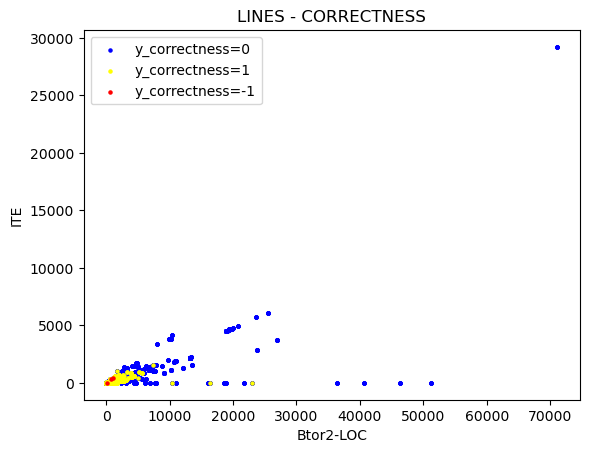

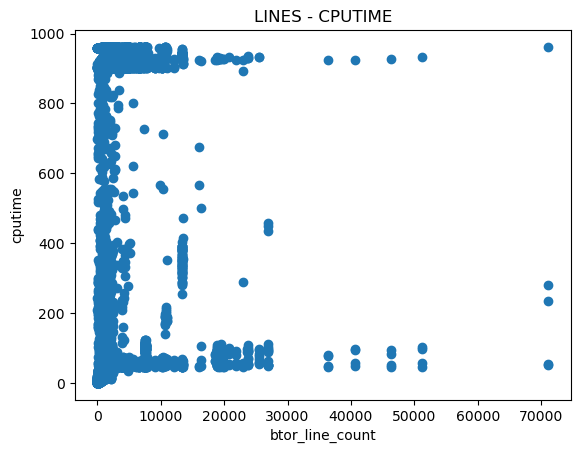

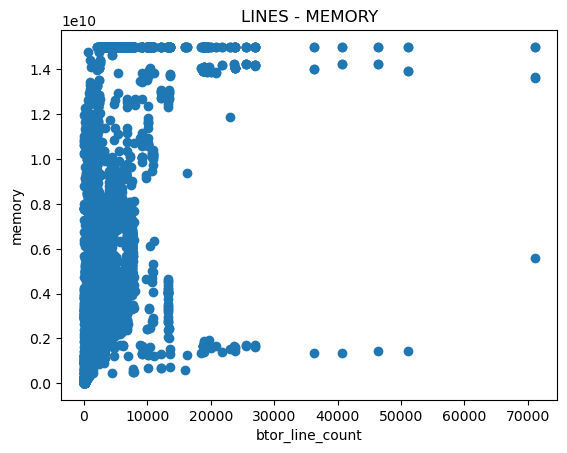

/home/hugh/formal/btor-algo-select/.conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/hugh/formal/btor-algo-select/.conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/hugh/formal/btor-algo-select/.conda/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


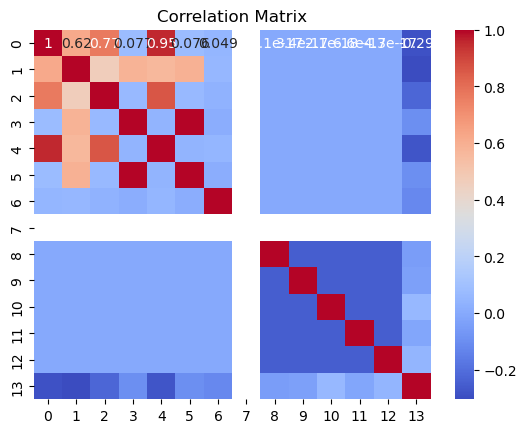

In [175]:
import numpy as np
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
print(len(X), len(y_correctness))

counts = Counter(y_correctness)
count_1 = counts[1]
count_0 = counts[0]
count_minus_1 = counts[-1]

print("Count of 1:", count_1)
print("Count of 0:", count_0)
print("Count of -1:", count_minus_1)

# plt.scatter(X[:, 0], X[:, 1], c=y_correctness)
# plt.scatter(X[:, 0], X[:, 1], c=y_correctness, cmap='viridis')
plt.scatter(X[y_correctness == 0, 0], X[y_correctness == 0, 2], c='blue', label='y_correctness=0', alpha=1, s=5)
plt.scatter(X[y_correctness == 1, 0], X[y_correctness == 1, 2], c='yellow', label='y_correctness=1', alpha=1, s=5)
plt.scatter(X[y_correctness == -1, 0], X[y_correctness == -1, 2], c='red', label='y_correctness=-1', alpha=1, s=5)
plt.xlabel('Btor2-LOC')
plt.ylabel('ITE')
plt.title('LINES - CORRECTNESS')
plt.legend()
plt.show()

plt.scatter(X[:, 0], y_cputime)
plt.xlabel('btor_line_count')
plt.ylabel('cputime')
plt.title('LINES - CPUTIME')
plt.show()

plt.scatter(X[:, 0], y_memory)
plt.xlabel('btor_line_count')
plt.ylabel('memory')
plt.title('LINES - MEMORY')
plt.show()

# import matplotlib.pyplot as plt

# # Calculate the correlation matrix
# corr_matrix = np.corrcoef(X.T, y_correctness)

# # Plot the correlation matrix as a heatmap
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()


In [162]:
from sklearn.metrics import f1_score
import numpy as np
from collections import Counter
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_correctness, test_size=0.2, random_state=47)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Create an SVM classifier with Gaussian kernel
clf = SVC(kernel='rbf', class_weight={
    1: 1.2, 
    0: 1, 
    -1: 1,
})
print(clf)

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
print(accuracy_score(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)

counts = Counter(y_test)
count_1 = counts[1]
count_0 = counts[0]
count_minus_1 = counts[-1]

print("Count of 1:", count_1)
print("Count of 0:", count_0)
print("Count of -1:", count_minus_1)


counts = Counter(y_pred)
count_1 = counts[1]
count_0 = counts[0]
count_minus_1 = counts[-1]

print("Count of 1:", count_1)
print("Count of 0:", count_0)
print("Count of -1:", count_minus_1)


(5364, 13) (1341, 13) (5364,) (1341,)
SVC(class_weight={-1: 1, 0: 1, 1: 1.2})
0.7524235645041014
0.7475881247101276
Count of 1: 342
Count of 0: 998
Count of -1: 1
Count of 1: 307
Count of 0: 1034
Count of -1: 0


In [173]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Create a random forest classifier
clf = RandomForestClassifier()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_correctness, test_size=0.2, random_state=42)

# Train your model on the training set
clf.fit(X_train, y_train)

# Evaluate the model on the testing set
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

f1 = f1_score(y_test, clf.predict(X_test), average = 'weighted')
print("F1 Score:", f1)

importance = clf.feature_importances_
sorted_indices = importance.argsort()[::-1]

print("Most useful features:")
for i in sorted_indices:
    print(f"{feature_names[i]}: {importance[i]}")




Accuracy: 0.8441461595824012
F1 Score: 0.8431834653859765
Most useful features:
btor2-LOC: 0.2551669274653061
c-LOC: 0.22364550604828257
btor2-ITE-COUNT: 0.2164694342288996
btor2-STATE-COUNT: 0.1728627107776644
CPA-PredAbs: 0.04110159186638865
btor2-CONSTRAINT-COUNT: 0.01574994163876375
c-IF-COUNT: 0.014944697262488428
ESBMC-Kind: 0.01487714189346146
VeriAbs-Default: 0.014869452420735025
ESBMC-BMC: 0.013882705512468426
CPA-NoPtrAlias: 0.013517450092249535
c-FOR-COUNT: 0.002912440793292031
c-WHILE-COUNT: 0.0
